In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [ ]:
# Load the dataset (make sure the CSV file is in the working directory)
df = pd.read_csv("TCS Historical Data.csv")

In [ ]:
# Convert the 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

<ipython-input-31-61bcd5824fb3>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# df[df['Price'].astype(str).str.contains(r'\d+\.\d+\.\d+')]

In [ ]:
df['Price'] = df['Price'].astype(str).str.replace(r'[^\d,]', '', regex=True)  # Remove non-numeric characters except commas
df['Price'] = df['Price'].str.replace(',', '.').astype(float)

In [ ]:
print(df['Price'].dtype)  # Should print 'float64'
print(df.head())  # Display cleaned values

float64
              Price      Open      High       Low   Vol. Change %
Date                                                             
2024-03-28  3.87630  3,850.10  3,915.00  3,840.50  4.31M    0.92%
2024-03-27  3.84090  3,888.50  3,895.00  3,829.40  1.97M   -0.94%
2024-03-26  3.87750  3,875.00  3,946.70  3,871.45  3.44M   -0.85%
2024-03-22  3.91090  3,897.00  3,938.00  3,855.00  5.85M   -1.56%
2024-03-21  3.97295  3,990.05  4,008.40  3,948.00  3.83M    0.05%


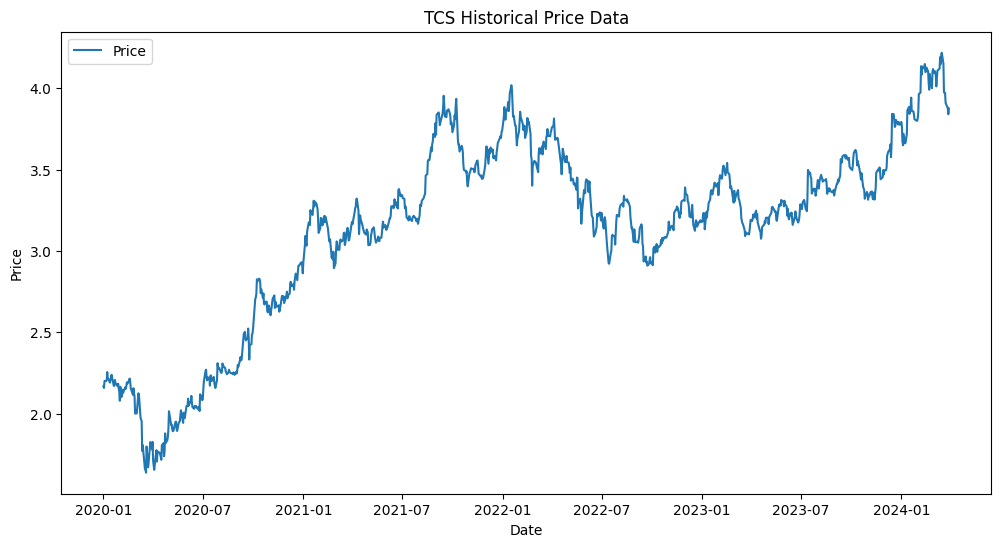

In [ ]:
# Visualize the data (optional)
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Price'], label="Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("TCS Historical Price Data")
plt.legend()
plt.show()

In [ ]:
# Scale the data to the range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
price_data = scaler.fit_transform(df[['Price']])


In [ ]:
# Define a function to create sequences for training/testing
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


In [ ]:
# Set look_back period (e.g., using 60 days of past data to predict the next day)
look_back = 60
X, y = create_dataset(price_data, look_back)


In [ ]:
# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
# Optionally, split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.1448 - val_loss: 0.0157
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0095 - val_loss: 0.0154
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0073 - val_loss: 0.0162
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0062 - val_loss: 0.0118
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0059 - val_loss: 0.0123
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0049 - val_loss: 0.0110
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0048 - val_loss: 0.0079
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0

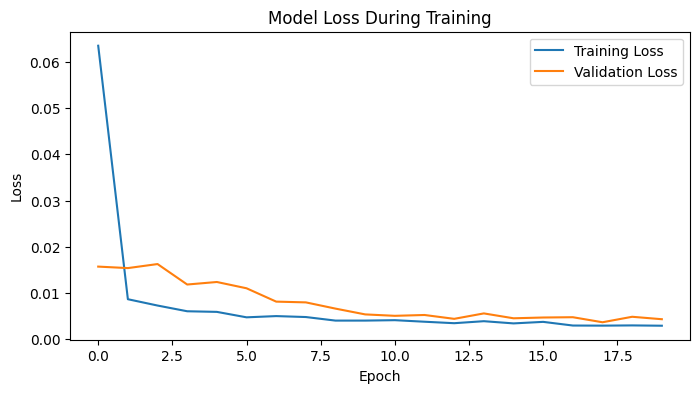

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss During Training")
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


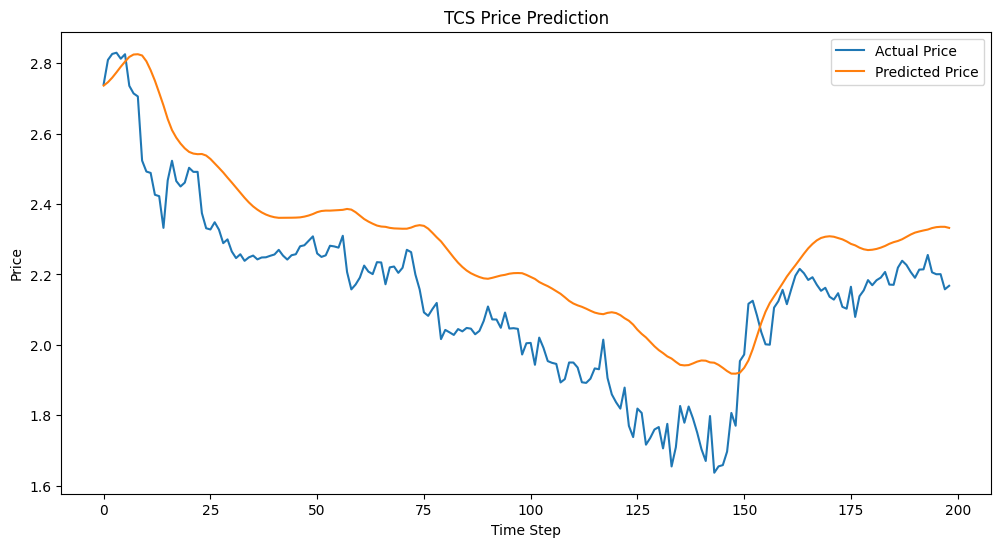

In [ ]:
# Plot predictions vs actual prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("TCS Price Prediction")
plt.legend()
plt.show()